## Introduction to Deep Learning Week 4: NLP Disaster Tweets Kaggle Mini-Project
### Sean Diab
#### 11/27/2024
#### Github Link: 
#### Kaggle Link: https://www.kaggle.com/competitions/nlp-getting-started/overview

In this project I will be given Tweets. The goal is to predict which tweets are about real disasters and which ones are not.


Imports:

In [17]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.head(), '\n')
print(test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


Preprocess the data (clean the data)

In [ ]:
def clean_text(text):
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.lower().strip()
    return text

train['cleaned_text'] = train['text'].apply(clean_text)
test['cleaned_text'] = test['text'].apply(clean_text)

combined_texts = pd.concat([train['cleaned_text'], test['cleaned_text']])

Tokenize and Pad Sequences

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_texts)

train_sequences = tokenizer.texts_to_sequences(train['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test['cleaned_text'])

MAX_LEN = 50
X_train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

y_train = train['target']

Load GLoVe Embeddings. These are pre-trained word embeddings. They capture contextual relationships between words.

In [23]:
# Load GloVe embeddings
embedding_dict = {}
with open("glove.6B.100d.txt", "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Train-Test Split

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

Build the model

In [25]:
inputs = Input(shape=(MAX_LEN,))
x = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=False
)(inputs)
x = SpatialDropout1D(0.2)(x)
x = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=1e-5)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

model.summary()

c:\Users\chees\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 50, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,042,305 (7.79 MB)

 Trainable params: 42,305 (165.25 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Train the Model

In [26]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=2
)

Epoch 1/15
191/191 - 4s - 20ms/step - accuracy: 0.5655 - loss: 0.6927 - val_accuracy: 0.5739 - val_loss: 0.6922
Epoch 2/15
191/191 - 2s - 10ms/step - accuracy: 0.5693 - loss: 0.6919 - val_accuracy: 0.5739 - val_loss: 0.6913
Epoch 3/15
191/191 - 2s - 11ms/step - accuracy: 0.5695 - loss: 0.6909 - val_accuracy: 0.5739 - val_loss: 0.6901
Epoch 4/15
191/191 - 2s - 11ms/step - accuracy: 0.5695 - loss: 0.6894 - val_accuracy: 0.5739 - val_loss: 0.6880
Epoch 5/15
191/191 - 2s - 11ms/step - accuracy: 0.5695 - loss: 0.6864 - val_accuracy: 0.5739 - val_loss: 0.6821
Epoch 6/15
191/191 - 2s - 10ms/step - accuracy: 0.5696 - loss: 0.6774 - val_accuracy: 0.5739 - val_loss: 0.6634
Epoch 7/15
191/191 - 2s - 10ms/step - accuracy: 0.5803 - loss: 0.6581 - val_accuracy: 0.5995 - val_loss: 0.6261
Epoch 8/15
191/191 - 2s - 10ms/step - accuracy: 0.6529 - loss: 0.6290 - val_accuracy: 0.7663 - val_loss: 0.5840
Epoch 9/15
191/191 - 2s - 10ms/step - accuracy: 0.7146 - loss: 0.6077 - val_accuracy: 0.7676 - val_loss:

Evaluate the Model

In [27]:
val_preds = (model.predict(X_val) > 0.5).astype(int).flatten()
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Accuracy: 0.7760998030203545
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.75      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



Make Predictions on Test Data

In [28]:
test_preds = (model.predict(X_test_padded) > 0.5).astype(int).flatten()

submission = pd.DataFrame({'id': test['id'], 'target': test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file created!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Submission file created!


Visualize Training Progress

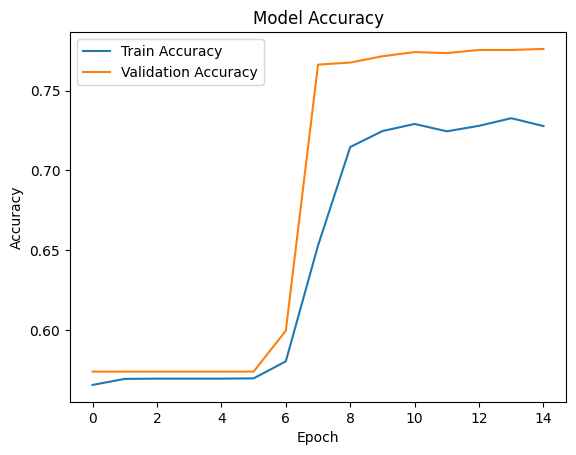

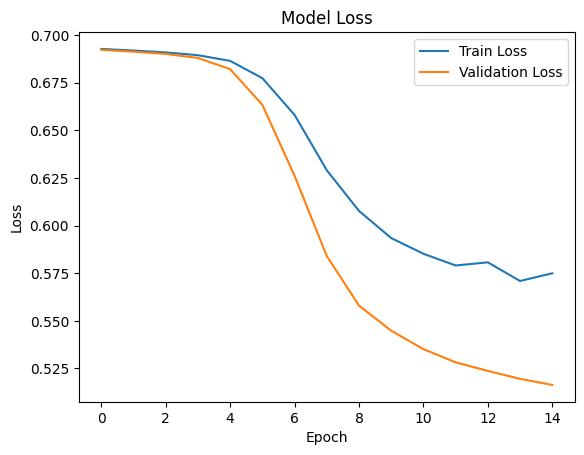

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Try another model: BiLSTM (Bidirectional LSTM)

In [30]:
from tensorflow.keras.layers import Bidirectional

inputs = Input(shape=(MAX_LEN,))
x = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=False
)(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)  # BiLSTM layer
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=1e-5)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

model.summary()

c:\Users\chees\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 50, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,084,609 (7.95 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Train the model

In [31]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=2
)

Epoch 1/15
191/191 - 6s - 31ms/step - accuracy: 0.5744 - loss: 0.6816 - val_accuracy: 0.6454 - val_loss: 0.6688
Epoch 2/15
191/191 - 2s - 12ms/step - accuracy: 0.6140 - loss: 0.6704 - val_accuracy: 0.6658 - val_loss: 0.6576
Epoch 3/15
191/191 - 2s - 13ms/step - accuracy: 0.6312 - loss: 0.6601 - val_accuracy: 0.6724 - val_loss: 0.6482
Epoch 4/15
191/191 - 2s - 13ms/step - accuracy: 0.6486 - loss: 0.6515 - val_accuracy: 0.6848 - val_loss: 0.6394
Epoch 5/15
191/191 - 2s - 13ms/step - accuracy: 0.6639 - loss: 0.6431 - val_accuracy: 0.6934 - val_loss: 0.6307
Epoch 6/15
191/191 - 2s - 13ms/step - accuracy: 0.6670 - loss: 0.6388 - val_accuracy: 0.7072 - val_loss: 0.6220
Epoch 7/15
191/191 - 2s - 13ms/step - accuracy: 0.6813 - loss: 0.6306 - val_accuracy: 0.7236 - val_loss: 0.6129
Epoch 8/15
191/191 - 2s - 13ms/step - accuracy: 0.6951 - loss: 0.6210 - val_accuracy: 0.7354 - val_loss: 0.6027
Epoch 9/15
191/191 - 2s - 13ms/step - accuracy: 0.7051 - loss: 0.6135 - val_accuracy: 0.7551 - val_loss:

Evaluate the model

In [35]:
from sklearn.metrics import classification_report, accuracy_score

val_preds = (model.predict(X_val) > 0.5).astype(int).flatten()
val_accuracy = accuracy_score(y_val, val_preds)

print(f"Validation Accuracy: {val_accuracy}")
print("Classification Report on Validation Set:")
print(classification_report(y_val, val_preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy: 0.7852921864740644
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       874
           1       0.76      0.72      0.74       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.79      0.78      1523



Make Predictions on Test Data

In [37]:
test_preds = (model.predict(X_test_padded) > 0.5).astype(int).flatten()

submission = pd.DataFrame({'id': test['id'], 'target': test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Submission file created successfully!


### Analysis:

The first model I trained had a validation accuracy of 0.776, and the second one I trained had a validation accuracy of 0.785. My public score for the Kaggle project was 0.76310.


### Conclusion:
This project attempted to predict which Tweets were about real disasters and which ones werent.  

We cleaned the data by removing URLS, HTML tags, punctuation and stopwords. Then we use pre-trained GloVe embeddings to help the model learn patterns effectively.

After that, we used two models: the LSTM and BiLSTM. The BiLSTM had slightly better results, with a validation accuracy of 0.785 and a public score of 0.76310.